In [5]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
import math
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *

In [6]:
path = "/Users/alvira/Desktop/distributedData/project/"

input_file_name1 = path+"review.json"
input_file_name2 = path+'business.json'
input_file_name3 = path+'user.json'
input_file_name4 = path+'msan-697/review2.json'

In [8]:
business = sqlContext.read.json(input_file_name2)

In [11]:
business = business.toPandas()

In [22]:
business.shape

(156639, 15)

In [78]:
rest = business[business['categories'].apply(lambda x: 'Restaurants' in x or "Food" in x or "Pubs" in x
                                             or "Nightlife" in x or "Bars" in x)]

In [79]:
rest.shape

(69042, 15)

In [46]:
rest.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open           int64
latitude        float64
longitude       float64
name             object
neighborhood     object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

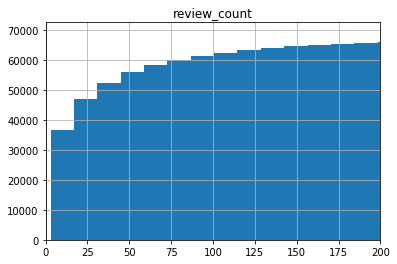

In [82]:
# rest['review_count'].plot(kind='bar')
fig=plt.figure()
rest.hist(column="review_count",bins=500,cumulative=True)
plt.xlim([0,200])
plt.show()

In [10]:
users = sqlContext.read.json(input_file_name3)

In [17]:
review_count = users.select(["review_count"]).toPandas()

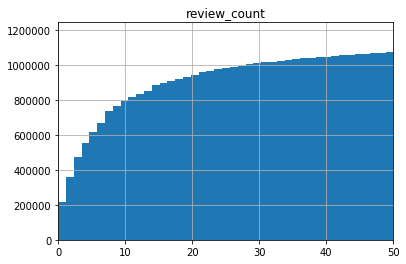

In [29]:
# rest['review_count'].plot(kind='bar')
fig=plt.figure()
review_count.hist(column="review_count",bins=10000,cumulative=True)
plt.xlim([0,50])
plt.show()

In [3]:
filt_reviews = sqlContext.read.json(input_file_name4).toPandas()

In [4]:
filt_reviews.shape

(1269069, 6)

In [38]:
filt_reviews['length'] = filt_reviews['text'].apply(lambda x: len(x))

In [21]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

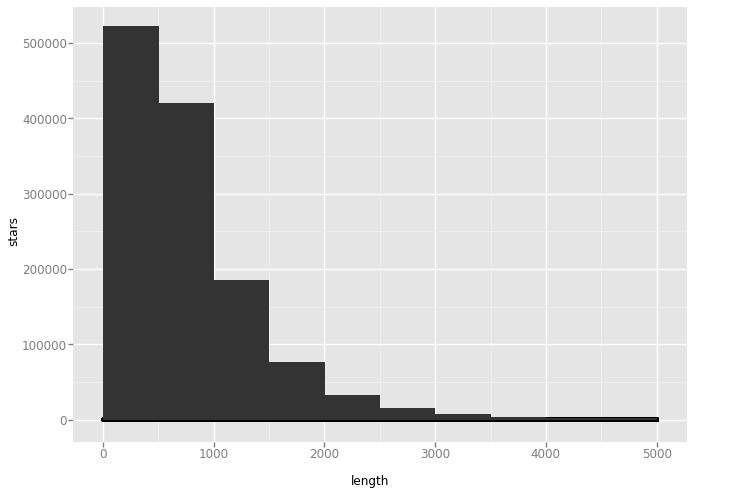

<ggplot: (284756673)>


In [36]:
print ggplot(aes(x = 'length'),data=filt_reviews) + geom_histogram() 

In [56]:
def bucket(x):
    if x<200: return "less than 200"
    elif x>=200 and x<500: return "between 200 and 500"
    elif x>=500 and x<800: return "between 500 and 800"
    elif x>=800 and x<1300: return "between 800 and 1300"
    elif x>=1300 and x<1600: return "between 1300 and 1600"
    else : return "greater than 1600"  
filt_reviews['length-bucket'] = filt_reviews['length'].apply(lambda x: bucket(x))

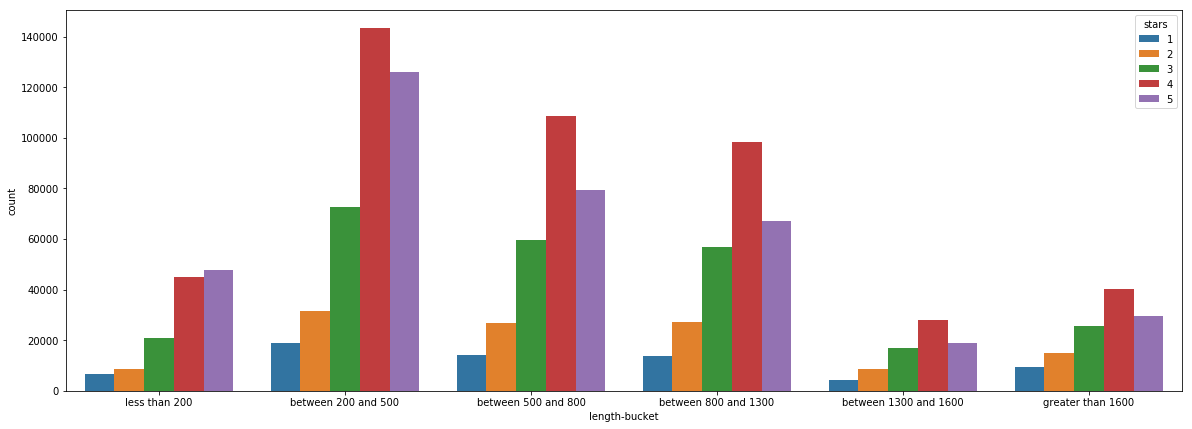

In [69]:
import seaborn as sns
plt.figure(figsize=(20,7))
sns.countplot(x="length-bucket", order= ["less than 200","between 200 and 500","between 500 and 800",
                                        "between 800 and 1300","between 1300 and 1600","greater than 1600"],
              hue="stars", data=filt_reviews)
plt.show()

## Distribution of length of reviews

In [2]:
filt_reviews['length'] = filt_reviews['text'].apply(lambda x: len(x.split()))

fig = plt.figure()
filt_reviews.hist(column='length')
plt.show()

In [ ]:
filt_reviews.head()

reviews2 = filt_reviews.copy()
#reviews2 = filt_reviews.withColumn('class',categorize('stars')).select(['text', 'class','stars','business_id', 'user_id'])

In [ ]:
reviews2['category'] = 0
reviews2['category'][reviews2['stars'] > 3] = 1
reviews2.head()

In [ ]:
reviews_pos = reviews2[reviews2['category'] == 1]
reviews_neg = reviews2[reviews2['category'] == 0]
print reviews_pos.shape, reviews_neg.shape
reviews_neg.head()

In [ ]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import re

In [ ]:
stopWords.add('-')
stopWords.add('would')
stopWords.add('get')
stopWords.remove('not')
stopWords.add('could')



In [ ]:
# stopWords

pos_reviews = sc.parallelize(reviews_pos['text'])

pos_reviews = pos_reviews.flatMap(lambda x:x.split(' ')).map(lambda x: x.lower()).map(lambda x: re.sub("'", '', x)).filter(lambda x: x is not u'').filter(lambda x:len(x)>3)

# pos_reviews.collect()

pos_reviews = pos_reviews.filter(lambda x: x not in stopWords)

# pos_reviews.collect()

pos_reviews = pos_reviews.map(lambda x: (x, 1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[1], ascending=False)

pos_reviews.take(20)

In [ ]:
# stopWords

neg_reviews = sc.parallelize(reviews_neg['text'])

neg_reviews = neg_reviews.flatMap(lambda x:x.split(' ')).map(lambda x: x.lower()).map(lambda x: re.sub("'", '', x)).filter(lambda x: x is not u'').filter(lambda x:len(x)>3)

# neg_reviews.collect()

neg_reviews = neg_reviews.filter(lambda x: x not in stopWords)

# neg_reviews.collect()

neg_reviews = neg_reviews.map(lambda x: (x, 1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[1], ascending=False)

neg_reviews.take(20)